<a href="https://colab.research.google.com/github/PriyanshuR23/Industrial_IOT_Predictive_Maintenance/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer #
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import joblib
from sklearn.metrics import classification_report,accuracy_score,precision_score, recall_score, f1_score

In [2]:
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Datasets/AI4I-PMDI.csv')

print(df.head())

Mounted at /content/drive
   UDI              Date  System Control Product ID Type  Air temperature (K)  \
0    1  15/04/2014 11:56       0       C     M14860    M                  NaN   
1    2  12/04/2014 16:09       0       A     L47181    L                298.2   
2    3  13/04/2014 01:13       0       A     L47182    L                298.1   
3    4  24/07/2014 20:35       0       B     L47183    L                  NaN   
4    5  22/07/2014 01:31       0       C     L47184    L                  NaN   

   Process temperature (K)  Rotational speed (rpm)  Torque (Nm)  \
0                      NaN                     NaN         42.8   
1                    308.7                  1408.0          NaN   
2                    308.5                  1498.0          NaN   
3                      NaN                  1433.0         39.5   
4                      NaN                     NaN         40.0   

   Tool wear (min)  Diagnostic  
0              0.0  No failure  
1              NaN

In [3]:
from IPython.display import display, HTML
display(HTML(df.head().to_html()))
print(df.isnull().sum())

,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic
0,1,15/04/2014 11:56,0,C,M14860,M,NaN,NaN,NaN,42.8,0.0,No failure
1,2,12/04/2014 16:09,0,A,L47181,L,298.2,308.7,1408.0,NaN,NaN,No failure
2,3,13/04/2014 01:13,0,A,L47182,L,298.1,308.5,1498.0,NaN,NaN,No failure
3,4,24/07/2014 20:35,0,B,L47183,L,NaN,NaN,1433.0,39.5,NaN,No failure
4,5,22/07/2014 01:31,0,C,L47184,L,NaN,NaN,NaN,40.0,9.0,No failure


UDI                           0
Date                          0
System                        0
Control                       0
Product ID                    0
Type                          0
Air temperature (K)        6563
Process temperature (K)    6563
Rotational speed (rpm)     3321
Torque (Nm)                3437
Tool wear (min)            6679
Diagnostic                    0
dtype: int64


In [4]:

unique_diagnostics = df['Diagnostic'].unique()
num_unique_diagnostics = len(unique_diagnostics)

print(f"Number of unique diagnostics: {num_unique_diagnostics}")
print(f"Unique diagnostic names: {unique_diagnostics}")

Number of unique diagnostics: 6
Unique diagnostic names: ['No failure' 'Power Failure' 'Overstrain Failure' 'Tool Wear Failure'
 'Random Failures' 'Heat Dissipation Failure']


***Assigning Numeric Values to the classes using Label Encoder.***

In [5]:
label_encoder = LabelEncoder()

label_encoder.fit(df['Diagnostic'])

# 'No failure' is always 0
diagnostic_classes = list(label_encoder.classes_)
diagnostic_classes.remove('No failure')
diagnostic_classes.insert(0, 'No failure')

# Apply the adjusted mapping
label_encoder.classes_ = np.array(diagnostic_classes, dtype=object)
df['Diagnostic_encoded'] = label_encoder.transform(df['Diagnostic'])

# Create a mapping dictionary for reference
diagnostic_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Print the mapping
print("Diagnostic Mapping:")
for diagnostic, encoded_value in diagnostic_mapping.items():
    print(f"{diagnostic}: {encoded_value}")

# Display the updated DataFrame with the encoded column
print("\nUpdated DataFrame with encoded 'Diagnostic' column:")
display(HTML(df.head().to_html()))

Diagnostic Mapping:
No failure: 0
Heat Dissipation Failure: 1
Overstrain Failure: 2
Power Failure: 3
Random Failures: 4
Tool Wear Failure: 5

Updated DataFrame with encoded 'Diagnostic' column:


,UDI,Date,System,Control,Product ID,Type,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic,Diagnostic_encoded
0,1,15/04/2014 11:56,0,C,M14860,M,NaN,NaN,NaN,42.8,0.0,No failure,0
1,2,12/04/2014 16:09,0,A,L47181,L,298.2,308.7,1408.0,NaN,NaN,No failure,0
2,3,13/04/2014 01:13,0,A,L47182,L,298.1,308.5,1498.0,NaN,NaN,No failure,0
3,4,24/07/2014 20:35,0,B,L47183,L,NaN,NaN,1433.0,39.5,NaN,No failure,0
4,5,22/07/2014 01:31,0,C,L47184,L,NaN,NaN,NaN,40.0,9.0,No failure,0


In [6]:
# Save the columns to be dropped
dropped_columns = df[['UDI', 'Date', 'System', 'Control', 'Product ID', 'Type', 'Diagnostic']]

# Create a new dataframe with dropped columns.
df_dropped = pd.DataFrame(dropped_columns)

# Export the dropped columns to a new CSV file
df_dropped.to_csv('/content/drive/MyDrive/Capstone/dropped_columns.csv', index=False)

# Drop the specified columns from the original DataFrame
df = df.drop(['UDI', 'Date', 'System', 'Control', 'Product ID', 'Type', 'Diagnostic'], axis=1)

# Display the updated DataFrame
print("\nDataFrame after dropping columns:")
display(HTML(df.head().to_html()))



DataFrame after dropping columns:


,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic_encoded
0,NaN,NaN,NaN,42.8,0.0,0
1,298.2,308.7,1408.0,NaN,NaN,0
2,298.1,308.5,1498.0,NaN,NaN,0
3,NaN,NaN,1433.0,39.5,NaN,0
4,NaN,NaN,NaN,40.0,9.0,0


In [7]:

import pandas as pd
for col in df.columns:
  if pd.api.types.is_numeric_dtype(df[col]):
    print(f"Column: {col}, Min: {df[col].min()}, Max: {df[col].max()}")


Column: Air temperature (K), Min: 295.4, Max: 304.3
Column: Process temperature (K), Min: 305.8, Max: 313.8
Column: Rotational speed (rpm), Min: 1168.0, Max: 2886.0
Column: Torque (Nm), Min: 3.8, Max: 76.6
Column: Tool wear (min), Min: 0.0, Max: 253.0
Column: Diagnostic_encoded, Min: 0, Max: 5


In [8]:
numerical_cols = df.select_dtypes(include=['number']).columns
# Create an IterativeImputer object with Bayesian Ridge
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42,tol =0.02)

# Apply imputation
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

# Apply constraints to keep values within reasonable limits
df['Air temperature (K)'] = np.clip(df['Air temperature (K)'], 295, 305)
df['Process temperature (K)'] = np.clip(df['Process temperature (K)'], 305, 314)
df['Rotational speed (rpm)'] = np.clip(df['Rotational speed (rpm)'], 1168, 2886)
df['Torque (Nm)'] = np.clip(df['Torque (Nm)'], 4, 77)
df['Tool wear (min)'] = np.clip(df['Tool wear (min)'], 0, 253)

# Display the updated DataFrame
print("\nUpdated DataFrame after imputing and clipping:")
display(HTML(df.head().to_html()))


Updated DataFrame after imputing and clipping:


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Air temperature (K),Process temperature (K),Rotational speed (rpm),Torque (Nm),Tool wear (min),Diagnostic_encoded
0,295.0,305.0,1168.0,42.800000,0.000000,0.0
1,298.2,308.7,1408.0,49.352130,101.735729,0.0
2,298.1,308.5,1498.0,44.847462,104.383550,0.0
3,295.0,305.0,1433.0,39.500000,77.538358,0.0
4,295.0,305.0,1168.0,40.000000,9.000000,0.0


In [9]:
# Count occurrences of each diagnostic
diagnostic_counts = df['Diagnostic_encoded'].value_counts()

# Calculate percentages
diagnostic_percentages = (diagnostic_counts / len(df)) * 100

# Print counts and percentages
print("Diagnostic Counts and Percentages:")
for diagnostic, count in diagnostic_counts.items():
    percentage = diagnostic_percentages[diagnostic]
    print(f"Diagnostic {diagnostic}: Count = {count}, Percentage = {percentage:.2f}%")

Diagnostic Counts and Percentages:
Diagnostic 0.0: Count = 9652, Percentage = 96.52%
Diagnostic 1.0: Count = 106, Percentage = 1.06%
Diagnostic 2.0: Count = 98, Percentage = 0.98%
Diagnostic 3.0: Count = 83, Percentage = 0.83%
Diagnostic 5.0: Count = 42, Percentage = 0.42%
Diagnostic 4.0: Count = 19, Percentage = 0.19%


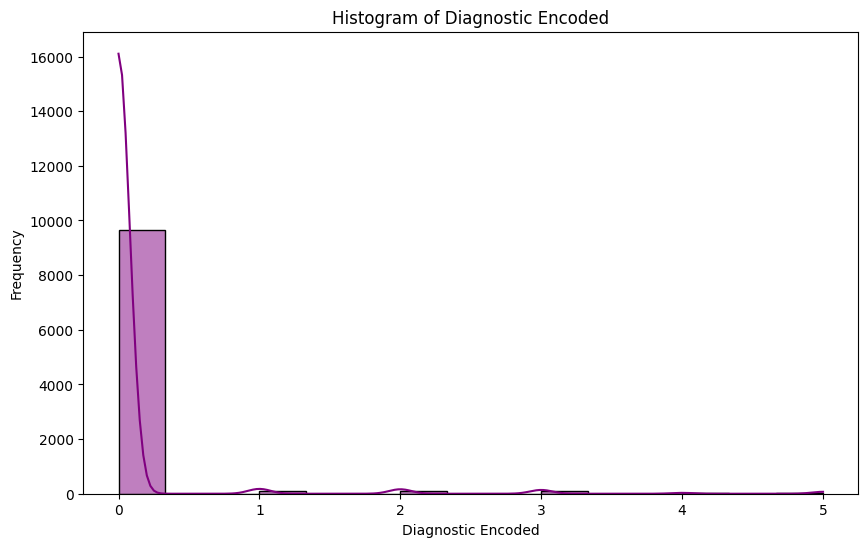

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Diagnostic_encoded'], kde=True,color="purple")
plt.title('Histogram of Diagnostic Encoded')
plt.xlabel('Diagnostic Encoded')
plt.ylabel('Frequency')
plt.show()


In [11]:
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# Assuming `df` is your original dataset
X = df.drop(columns=['Diagnostic_encoded'])  # Features
y = df['Diagnostic_encoded']                 # Target Variable

# Define new sampling strategy based on encoded values
sampling_strategy = {
    1.0: 4800,
    2.0: 3700,
    3.0: 3500,
    5.0: 3900,
    4.0: 3200
}

# Apply SMOTE with custom distribution
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame
df = pd.DataFrame(X_resampled, columns=X.columns)
df['Diagnostic_encoded'] = y_resampled

# Check new class distribution
print(df['Diagnostic_encoded'].value_counts(normalize=True) * 100)

Diagnostic_encoded
0.0    33.569839
1.0    16.694491
5.0    13.564274
2.0    12.868670
3.0    12.173066
4.0    11.129661
Name: proportion, dtype: float64


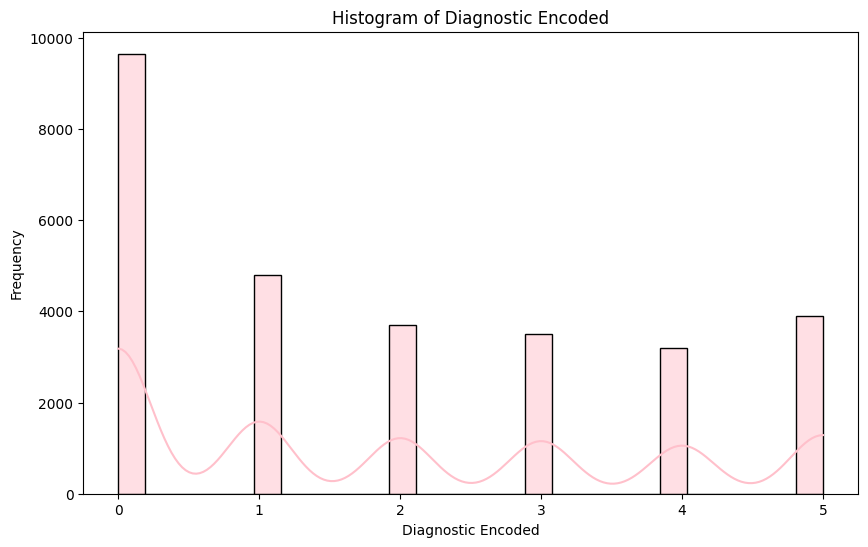

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Diagnostic_encoded'], kde=True,color="pink")
plt.title('Histogram of Diagnostic Encoded')
plt.xlabel('Diagnostic Encoded')
plt.ylabel('Frequency')
plt.show()


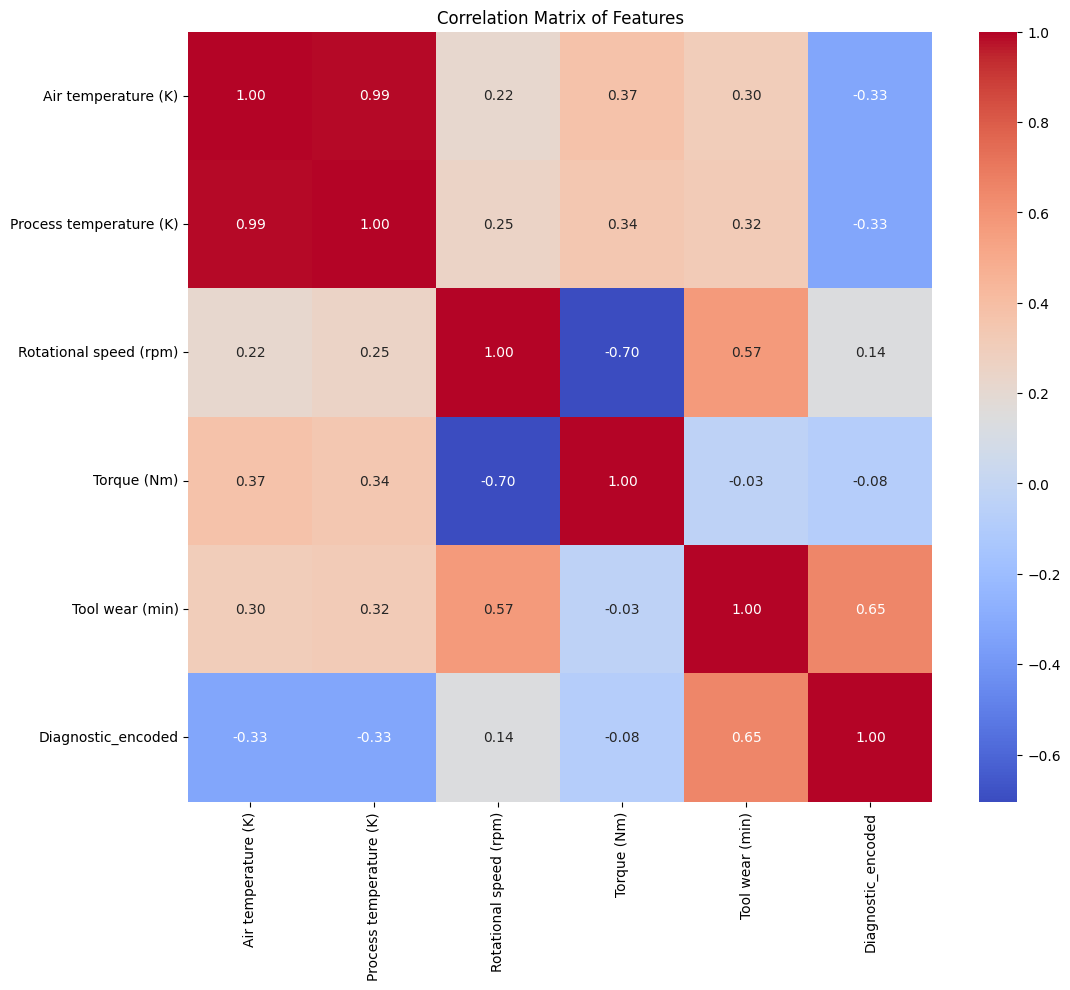

In [13]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()


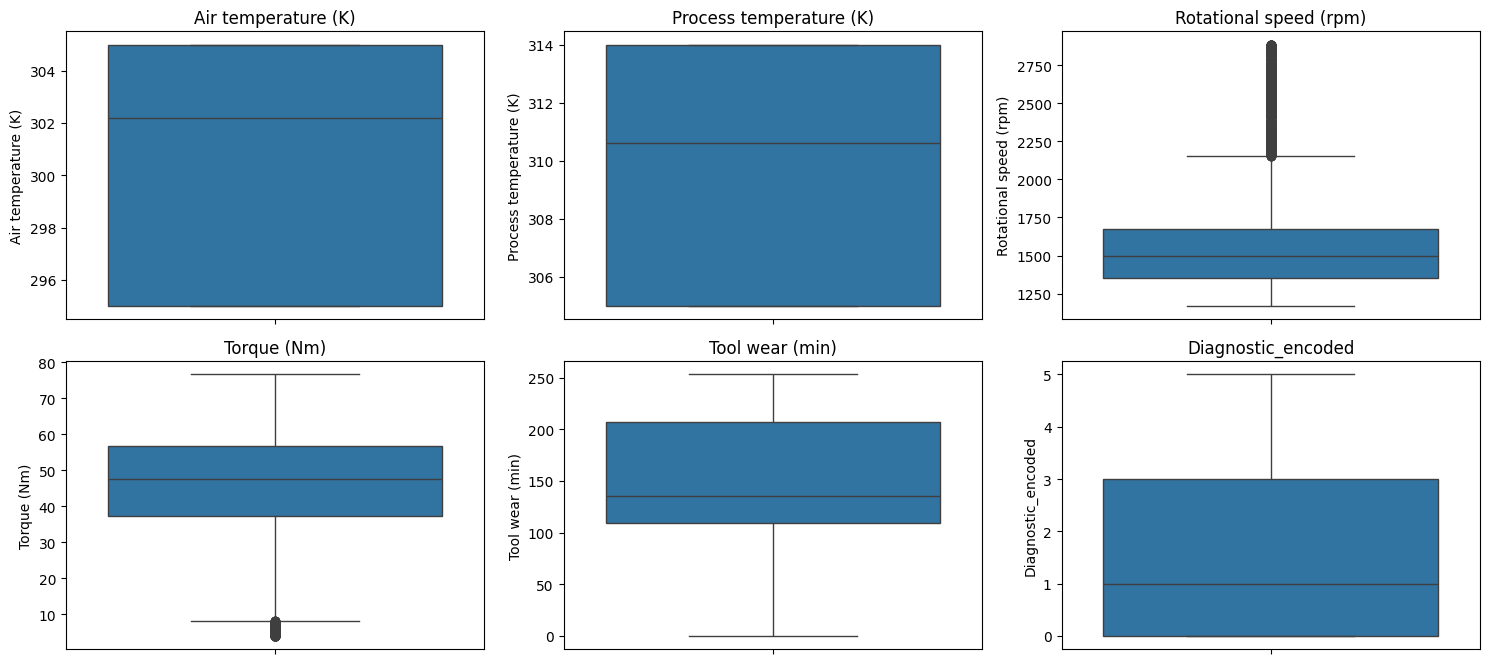

In [14]:
# Create box plots for all numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(df.select_dtypes(include=np.number).columns):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


In [15]:
def calculate_iqr_outliers(df):
  """
  Calculates the IQR and counts outliers for numerical features in a DataFrame.

  Args:
    df: The DataFrame to analyze.

  Returns:
    A dictionary with feature names as keys and a tuple of (IQR, outlier_count) as values.
  """
  outlier_info = {}
  for column in df.select_dtypes(include=['number']).columns:
    if column != 'Diagnostic_encoded':  # Exclude the target variable
      Q1 = df[column].quantile(0.25)
      Q3 = df[column].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      outlier_count = len(df[(df[column] < lower_bound) | (df[column] > upper_bound)])
      outlier_info[column] = (IQR, outlier_count)
  return outlier_info

# Calculate IQR and outlier counts for df_balanced
outlier_counts_df = calculate_iqr_outliers(df)


# Print the results
for feature, (IQR, outlier_count) in outlier_counts_df.items():
  print(f"Feature: {feature}, IQR: {IQR:.2f}, Outlier Count: {outlier_count}")

Feature: Air temperature (K), IQR: 10.00, Outlier Count: 0
Feature: Process temperature (K), IQR: 9.00, Outlier Count: 0
Feature: Rotational speed (rpm), IQR: 318.78, Outlier Count: 1693
Feature: Torque (Nm), IQR: 19.46, Outlier Count: 267
Feature: Tool wear (min), IQR: 97.59, Outlier Count: 0


In [ ]:
# # Define the IQR range for 'Rotational speed (rpm)' and 'Tool wear (min)'
# Q1 = df[['Rotational speed (rpm)', 'Tool wear (min)']].quantile(0.25)
# Q3 = df[['Rotational speed (rpm)', 'Tool wear (min)']].quantile(0.75)
# IQR = Q3 - Q1

# # Define outlier boundaries
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# # Filter the DataFrame to remove outliers
# df = df[
#     (df['Rotational speed (rpm)'] >= lower_bound['Rotational speed (rpm)']) &
#     (df['Rotational speed (rpm)'] <= upper_bound['Rotational speed (rpm)']) &
#     (df['Tool wear (min)'] >= lower_bound['Tool wear (min)']) &
#     (df['Tool wear (min)'] <= upper_bound['Tool wear (min)'])
# ]

# print(f"New dataset shape after outlier removal: {df.shape}")


In [16]:
print(df['Diagnostic_encoded'].nunique())


6


In [17]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=['Diagnostic_encoded'])
y = df['Diagnostic_encoded']

# Get unique classes
classes = y.unique()

# Separate out each class
X_class = {cls: X[y == cls] for cls in classes}
y_class = {cls: y[y == cls] for cls in classes}

# Set aside at least one sample from each class for test
X_test_list = []
y_test_list = []

for cls in classes:
    X_cls, X_remaining, y_cls, y_remaining = train_test_split(
        X_class[cls], y_class[cls], test_size=0.8, random_state=42  # Keep 20% as test
    )

    X_test_list.append(X_cls)
    y_test_list.append(y_cls)

    X_class[cls] = X_remaining
    y_class[cls] = y_remaining

# Combine test sets
X_test = pd.concat(X_test_list, axis=0)
y_test = pd.concat(y_test_list, axis=0)

# Combine remaining samples and split into train/val
X_remaining = pd.concat(X_class.values(), axis=0)
y_remaining = pd.concat(y_class.values(), axis=0)

X_train, X_val, y_train, y_val = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=42, stratify=y_remaining
)

# Print class distributions
print("Class distribution in training set:\n", y_train.value_counts())
print("Class distribution in test set:\n", y_test.value_counts())

Class distribution in training set:
 Diagnostic_encoded
0.0    6177
1.0    3072
5.0    2496
2.0    2368
3.0    2240
4.0    2048
Name: count, dtype: int64
Class distribution in test set:
 Diagnostic_encoded
0.0    1930
1.0     960
5.0     780
2.0     740
3.0     700
4.0     640
Name: count, dtype: int64


In [18]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
!pip install pytorch-tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [21]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

# Create sample weights based on the training labels
sample_weights = np.array([class_weights_dict[label] for label in y_train])

# Initialize the TabNet model with stronger regularization
tabnet_model = TabNetClassifier(
    n_d=6,               # Dimension of the prediction layer
    n_a=6,               # Dimension of the attention layer
    n_steps=3,           # Number of steps in the architecture
    gamma=1.3,           # Slightly lower scaling factor (reduces sensitivity)
    lambda_sparse=1e-3,  # Higher sparsity regularization (prevents overfitting)
    optimizer_params=dict(lr=1e-3),  # Lower learning rate (more stable training)
    scheduler_params={"step_size":8, "gamma":0.8},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,  # Learning rate scheduler
    mask_type='entmax',   # Masking function
    momentum=0.35         # Adds Dropout to prevent overfitting
)

# Train the model with sample weights and early stopping
tabnet_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    eval_name=['test'],
    eval_metric=['accuracy'],  # More robust evaluation metric
    max_epochs=25,  # Reduce training time to prevent memorization
    patience=3,  # Stop training if no improvement in x epochs
    batch_size=1024,  # Reduce batch size (helps generalization)
    virtual_batch_size=1024,
    num_workers=0,
    weights=sample_weights,  # Apply class weights
    drop_last=False
)

# Save the trained model
joblib.dump(tabnet_model, "tabnet_model.pkl")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.09695 | test_accuracy: 0.30609 |  0:00:01s
epoch 1  | loss: 1.69323 | test_accuracy: 0.44052 |  0:00:02s
epoch 2  | loss: 1.47189 | test_accuracy: 0.53026 |  0:00:03s
epoch 3  | loss: 1.29948 | test_accuracy: 0.56087 |  0:00:03s
epoch 4  | loss: 1.17193 | test_accuracy: 0.60713 |  0:00:04s
epoch 5  | loss: 1.06288 | test_accuracy: 0.6807  |  0:00:05s
epoch 6  | loss: 0.95299 | test_accuracy: 0.71252 |  0:00:06s
epoch 7  | loss: 0.85091 | test_accuracy: 0.73217 |  0:00:07s
epoch 8  | loss: 0.76323 | test_accuracy: 0.73635 |  0:00:08s
epoch 9  | loss: 0.69465 | test_accuracy: 0.74748 |  0:00:08s
epoch 10 | loss: 0.64285 | test_accuracy: 0.75183 |  0:00:09s
epoch 11 | loss: 0.59164 | test_accuracy: 0.75583 |  0:00:10s
epoch 12 | loss: 0.5582  | test_accuracy: 0.7593  |  0:00:11s
epoch 13 | loss: 0.51867 | test_accuracy: 0.77165 |  0:00:12s
epoch 14 | loss: 0.4995  | test_accuracy: 0.776   |  0:00:13s
epoch 15 | loss: 0.46183 | test_accuracy: 0.77843 |  0:00:15s
epoch 16

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


['tabnet_model.pkl']

In [22]:
# Make predictions on test data
y_pred = tabnet_model.predict(X_test_scaled)

# Print evaluation metrics
print("Model Performance Metrics:")
print(classification_report(y_test, y_pred, digits=4))

Model Performance Metrics:
              precision    recall  f1-score   support

         0.0     0.9972    0.9259    0.9602      1930
         1.0     0.9905    0.9781    0.9843       960
         2.0     0.9933    0.9959    0.9946       740
         3.0     0.9955    0.9543    0.9745       700
         4.0     0.7968    0.9984    0.8863       640
         5.0     0.9811    1.0000    0.9905       780

    accuracy                         0.9652      5750
   macro avg     0.9591    0.9755    0.9651      5750
weighted avg     0.9709    0.9652    0.9663      5750



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

class NativeSparseAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super(NativeSparseAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        assert self.head_dim * num_heads == dim, "dim must be divisible by num_heads"

        self.query = nn.Linear(dim, dim)
        self.key = nn.Linear(dim, dim)
        self.value = nn.Linear(dim, dim)
        self.proj = nn.Linear(dim, dim)

        # Sparse attention parameters
        self.dropout = nn.Dropout(0.1)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        batch_size, seq_len, dim = x.size()

        # Project queries, keys, and values
        q = self.query(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.key(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.value(x).reshape(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale

        # Apply sparse mask (keeping only top-k values per row)
        k = min(int(seq_len * 0.3), seq_len)  # Keep top 30% of values
        topk_values, topk_indices = torch.topk(scores, k, dim=-1)
        sparse_scores = torch.zeros_like(scores).scatter_(-1, topk_indices, topk_values)

        # Apply softmax and dropout
        attn = F.softmax(sparse_scores, dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        out = torch.matmul(attn, v).permute(0, 2, 1, 3).reshape(batch_size, seq_len, dim)
        out = self.proj(out)

        return out

class NSALayer(nn.Module):
    def __init__(self, dim, num_heads):
        super(NSALayer, self).__init__()
        self.attention = NativeSparseAttention(dim, num_heads)
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Linear(dim * 4, dim)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        # Attention block
        attn_output = self.attention(x)
        x = self.norm1(x + attn_output)

        # Feed-forward block
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

class TabNSA(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64, num_heads=4, num_layers=3):
        super(TabNSA, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Input embedding
        self.embedding = nn.Linear(input_dim, hidden_dim)

        # NSA layers
        self.nsa_layers = nn.ModuleList([NSALayer(hidden_dim, num_heads) for _ in range(num_layers)])

        # Output layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Reshape input to add sequence dimension if it's just (batch_size, features)
        if len(x.shape) == 2:
            x = x.unsqueeze(1)  # (batch_size, 1, features)

        # Embed input features
        x = self.embedding(x)

        # Apply NSA layers
        for layer in self.nsa_layers:
            x = layer(x)

        # Take the output of the last position
        x = x.squeeze(1) if x.size(1) == 1 else x.mean(dim=1)

        # Classification head
        x = self.fc(x)

        return x

In [24]:
def prepare_data(X_train_scaled, y_train_scaled, batch_size=32, test_size=0.2, random_state=42):
    # # Split the data into training and validation sets
    # X_train_split, X_val, y_train_split, y_val = train_test_split(
    #     X_train_scaled, y_train_, test_size=test_size, random_state=random_state, stratify=y_train
    # )

    # # Scale the features
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train_split)
    # X_val_scaled = scaler.transform(X_val)

    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_test_scaled)
    y_val_tensor = torch.LongTensor(y_test.values)

    # Create DataLoader objects
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader, scaler

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=100, patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total

        # Print statistics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

        # Save statistics
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_tabnsa_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    return model, history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

    return test_loss, test_acc, all_preds, all_targets

In [25]:
def main(X_train, y_train):
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Hyperparameters
    input_dim = X_train.shape[1]
    output_dim = 6  # Number of classes (0-5)
    hidden_dim = 64
    num_heads = 4
    num_layers = 3
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 5

    # Prepare data
    train_loader, val_loader, scaler = prepare_data(X_train, y_train, batch_size=batch_size)

    # Initialize model
    model = TabNSA(
        input_dim=input_dim,
        output_dim=output_dim,
        hidden_dim=hidden_dim,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    model, history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        num_epochs=num_epochs
    )

    # Load the best model
    joblib.dump(model, "tabnsa_model.pkl") #Saving in mulitple modes for easier access during Ensemble creation
    model.load_state_dict(torch.load('best_tabnsa_model.pth'))

    # Evaluate on validation set
    val_loss, val_acc, val_preds, val_targets = evaluate_model(
        model=model,
        test_loader=val_loader,
        criterion=criterion,
        device=device
    )

    print(f"Final validation accuracy: {val_acc:.4f}")

    return model, scaler, history


In [26]:
import os

# Train the model
model, scaler, history = main(X_train_scaled, y_train)


Using device: cpu
Epoch 1/5 | Train Loss: 0.1635 | Train Acc: 0.9480 | Val Loss: 0.0544 | Val Acc: 0.9802
Epoch 2/5 | Train Loss: 0.0498 | Train Acc: 0.9792 | Val Loss: 0.0555 | Val Acc: 0.9739
Epoch 3/5 | Train Loss: 0.0502 | Train Acc: 0.9789 | Val Loss: 0.0419 | Val Acc: 0.9788
Epoch 4/5 | Train Loss: 0.0394 | Train Acc: 0.9813 | Val Loss: 0.0477 | Val Acc: 0.9784
Epoch 5/5 | Train Loss: 0.0456 | Train Acc: 0.9798 | Val Loss: 0.0245 | Val Acc: 0.9877
Test Loss: 0.0245 | Test Acc: 0.9877
Final validation accuracy: 0.9877


In [27]:
def test_model(model, X_test_scaled, y_test, batch_size=64):
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test.values)

    # Create test DataLoader
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set model to evaluation mode
    model.eval()

    # Initialize metrics
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_preds = []
    all_targets = []

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Calculate statistics
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()

            # Store predictions and targets for further analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Calculate final metrics
    test_loss = test_loss / len(test_loader.dataset)
    test_acc = test_correct / test_total

    print(f'Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')

    return test_loss, test_acc, all_preds, all_targets

# Load the best model
model_path = 'best_tabnsa_model.pth'
input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

# Initialize model with same architecture
model = TabNSA(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers
)

# Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

# Test the model
test_loss, test_acc, test_preds, test_targets = test_model(model, X_test_scaled, y_test)

# Optional: You can add more detailed evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(test_targets, test_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(test_targets, test_preds))

Test Loss: 0.0245 | Test Accuracy: 0.9877

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1930
           1       1.00      1.00      1.00       960
           2       1.00      1.00      1.00       740
           3       1.00      1.00      1.00       700
           4       0.91      0.99      0.95       640
           5       1.00      1.00      1.00       780

    accuracy                           0.99      5750
   macro avg       0.98      0.99      0.99      5750
weighted avg       0.99      0.99      0.99      5750


Confusion Matrix:
[[1868    0    0    0   62    0]
 [   0  960    0    0    0    0]
 [   0    0  740    0    0    0]
 [   0    0    0  699    1    0]
 [   8    0    0    0  632    0]
 [   0    0    0    0    0  780]]


In [28]:
# Step 1: Obtain probabilistic predictions from each model
# TabNet predictions (assuming tabnet_model is already trained)
# Load the TabNet model instead of re-initializing it
tabnet_model = joblib.load("tabnet_model.pkl")
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)

# The rest of your code to load and use the TabNSA model remains the same...

# Load the trained TabNSA model
input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

# Initialize the model with the same architecture
tabnsa_model = TabNSA(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers
)

# Load the saved weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tabnsa_model.load_state_dict(torch.load('best_tabnsa_model.pth', map_location=device))
tabnsa_model = tabnsa_model.to(device)
tabnsa_model.eval()

# Get TabNSA predictions
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = torch.softmax(outputs, dim=1).cpu().numpy()

# Step 2: Assign fixed weights
weight_tabnet = 0.8
weight_tabnsa = 0.2

# Step 3: Compute weighted average of predictions
y_proba_ensemble = (weight_tabnet * y_proba_tabnet) + (weight_tabnsa * y_proba_tabnsa)

# Step 4: Make final predictions

y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

Ensemble Model Accuracy: 0.9739
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.94      0.97      1930
         1.0       0.99      1.00      1.00       960
         2.0       0.99      1.00      1.00       740
         3.0       1.00      0.96      0.98       700
         4.0       0.84      1.00      0.91       640
         5.0       0.98      1.00      0.99       780

    accuracy                           0.97      5750
   macro avg       0.97      0.98      0.97      5750
weighted avg       0.98      0.97      0.97      5750



In [29]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBR": XGBClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "MLP": MLPClassifier(random_state=42)
}


In [30]:
# Train and save tree-based models on X_train
for name in ["Random Forest", "XGBR"]:
    print(f"Training {name}...")
    models[name].fit(X_train, y_train)
    joblib.dump(models[name], f"{name}.pkl")
    print(f"{name} saved as {name}.pkl")

# Train and save other models on X_train_scaled
for name in ["SVM", "KNN", "MLP"]:
    print(f"Training {name}...")
    models[name].fit(X_train_scaled, y_train)
    joblib.dump(models[name], f"{name}.pkl")
    print(f"{name} saved as {name}.pkl")

Training Random Forest...
Random Forest saved as Random Forest.pkl
Training XGBR...
XGBR saved as XGBR.pkl
Training SVM...
SVM saved as SVM.pkl
Training KNN...
KNN saved as KNN.pkl
Training MLP...
MLP saved as MLP.pkl


In [42]:
# Testing the models
for name in models.keys():
    model = joblib.load(f"{name}.pkl")
    if name in ["Random Forest", "XGBR"]:
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)
        X_used = X_test
    else:
        y_pred = model.predict(X_test_scaled) #isme scaled daalna hai
        y_proba = model.predict_proba(X_test_scaled)
        X_used = X_test_scaled

    accuracy = model.score(X_used, y_test)
    print(f"{name} Accuracy: {accuracy}")

    # Print classification report
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))

Random Forest Accuracy: 0.9951304347826087
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      1930
         1.0       1.00      1.00      1.00       960
         2.0       1.00      1.00      1.00       740
         3.0       1.00      1.00      1.00       700
         4.0       0.97      0.99      0.98       640
         5.0       1.00      1.00      1.00       780

    accuracy                           1.00      5750
   macro avg       0.99      1.00      1.00      5750
weighted avg       1.00      1.00      1.00      5750

XGBR Accuracy: 0.9937391304347826
XGBR Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      1930
         1.0       1.00      1.00      1.00       960
         2.0       1.00      1.00      1.00       740
         3.0       1.00      1.00      1.00       700
         4.0       0.97      0.98      0.98 

In [43]:
import joblib
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# Load trained models
tabnet_model = joblib.load("tabnet_model.pkl")
rf_model = joblib.load("Random Forest.pkl")
xgb_model = joblib.load("XGBR.pkl")
svm_model = joblib.load("SVM.pkl")
mlp_model = joblib.load("MLP.pkl")
knn_model = joblib.load("KNN.pkl")


# Get probabilistic predictions
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)
y_proba_svm = svm_model.predict_proba(X_test_scaled)
y_proba_mlp = mlp_model.predict_proba(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)

# Load and prepare TabNSA model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

tabnsa_model = TabNSA(input_dim, output_dim, hidden_dim, num_heads, num_layers)
tabnsa_model.load_state_dict(torch.load("best_tabnsa_model.pth", map_location=device))
tabnsa_model.to(device)
tabnsa_model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = softmax(outputs, dim=1).cpu().numpy()

# Assign model weights (can be adjusted based on validation performance)
weights = {
    "tabnet": 0.2,
    "tabnsa": 0.4,
    "rf": 0.1,
    "xgb": 0.1,
    "svm": 0.1,
    "mlp": 0.1,
    "knn": 0.1

}

# Compute weighted average of predictions
y_proba_ensemble = (
    weights["tabnet"] * y_proba_tabnet +
    weights["tabnsa"] * y_proba_tabnsa +
    weights["rf"] * y_proba_rf +
    weights["xgb"] * y_proba_xgb +
    weights["svm"] * y_proba_svm +
    weights["mlp"] * y_proba_mlp +
    weights["knn"] * y_proba_knn
)

# Final ensemble predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Ensemble Model Accuracy: 0.9908
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1930
         1.0       1.00      1.00      1.00       960
         2.0       1.00      1.00      1.00       740
         3.0       1.00      1.00      1.00       700
         4.0       0.95      0.97      0.96       640
         5.0       1.00      1.00      1.00       780

    accuracy                           0.99      5750
   macro avg       0.99      0.99      0.99      5750
weighted avg       0.99      0.99      0.99      5750



In [52]:
import joblib
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# Load trained models
tabnet_model = joblib.load("tabnet_model.pkl")
rf_model = joblib.load("Random Forest.pkl")
xgb_model = joblib.load("XGBR.pkl")
svm_model = joblib.load("SVM.pkl")
mlp_model = joblib.load("MLP.pkl")
knn_model = joblib.load("KNN.pkl")


# Get probabilistic predictions
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)
y_proba_svm = svm_model.predict_proba(X_test)
y_proba_mlp = mlp_model.predict_proba(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)

# Load and prepare TabNSA model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

tabnsa_model = TabNSA(input_dim, output_dim, hidden_dim, num_heads, num_layers)
tabnsa_model.load_state_dict(torch.load("best_tabnsa_model.pth", map_location=device))
tabnsa_model.to(device)
tabnsa_model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = softmax(outputs, dim=1).cpu().numpy()

# Assign model weights (can be adjusted based on validation performance)
weights = {
    "tabnet": 0.2,
    "tabnsa": 0.2,
    "rf": 0.1,
    "xgb": 0.1,
    "svm": 0.1,
    "mlp": 0.2,
    "knn": 0.1

}

# Compute weighted average of predictions
y_proba_ensemble = (
    weights["tabnet"] * y_proba_tabnet +
    weights["tabnsa"] * y_proba_tabnsa +
    weights["rf"] * y_proba_rf +
    weights["xgb"] * y_proba_xgb +
    weights["svm"] * y_proba_svm +
    weights["mlp"] * y_proba_mlp +
    weights["knn"] * y_proba_knn
)

# Final ensemble predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble,digits=4))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Ensemble Model Accuracy: 0.9934
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9974    0.9829    0.9901      1930
         1.0     1.0000    1.0000    1.0000       960
         2.0     1.0000    1.0000    1.0000       740
         3.0     1.0000    1.0000    1.0000       700
         4.0     0.9506    0.9922    0.9709       640
         5.0     1.0000    1.0000    1.0000       780

    accuracy                         0.9934      5750
   macro avg     0.9913    0.9958    0.9935      5750
weighted avg     0.9936    0.9934    0.9934      5750



In [51]:
#Knn + Tannet + TabNSA
import joblib
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# Load trained models
tabnet_model = joblib.load("tabnet_model.pkl")
rf_model = joblib.load("Random Forest.pkl")
xgb_model = joblib.load("XGBR.pkl")
svm_model = joblib.load("SVM.pkl")
mlp_model = joblib.load("MLP.pkl")
knn_model = joblib.load("KNN.pkl")


# Get probabilistic predictions
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)
y_proba_svm = svm_model.predict_proba(X_test)
y_proba_mlp = mlp_model.predict_proba(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)

# Load and prepare TabNSA model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

tabnsa_model = TabNSA(input_dim, output_dim, hidden_dim, num_heads, num_layers)
tabnsa_model.load_state_dict(torch.load("best_tabnsa_model.pth", map_location=device))
tabnsa_model.to(device)
tabnsa_model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = softmax(outputs, dim=1).cpu().numpy()

# Assign model weights (can be adjusted based on validation performance)
weights = {
    "tabnet": 0.4,
    "tabnsa": 0.4,
    "knn": 0.2

}

# Compute weighted average of predictions
y_proba_ensemble = (
    weights["tabnet"] * y_proba_tabnet +
    weights["tabnsa"] * y_proba_tabnsa +

    weights["knn"] * y_proba_knn
)

# Final ensemble predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble,digits=4))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Ensemble Model Accuracy: 0.9871
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9995    0.9642    0.9815      1930
         1.0     1.0000    1.0000    1.0000       960
         2.0     1.0000    1.0000    1.0000       740
         3.0     1.0000    0.9943    0.9971       700
         4.0     0.8975    0.9984    0.9453       640
         5.0     1.0000    1.0000    1.0000       780

    accuracy                         0.9871      5750
   macro avg     0.9828    0.9928    0.9873      5750
weighted avg     0.9884    0.9871    0.9874      5750



In [50]:
#SVM + TabNSA
import joblib
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# Load trained models
tabnet_model = joblib.load("tabnet_model.pkl")
svm_model = joblib.load("SVM.pkl")



# Get probabilistic predictions
y_proba_tabnet = tabnet_model.predict_proba(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)
y_proba_svm = svm_model.predict_proba(X_test)
y_proba_mlp = mlp_model.predict_proba(X_test_scaled)
y_proba_knn = knn_model.predict_proba(X_test_scaled)

# Load and prepare TabNSA model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

tabnsa_model = TabNSA(input_dim, output_dim, hidden_dim, num_heads, num_layers)
tabnsa_model.load_state_dict(torch.load("best_tabnsa_model.pth", map_location=device))
tabnsa_model.to(device)
tabnsa_model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = softmax(outputs, dim=1).cpu().numpy()

# Assign model weights (can be adjusted based on validation performance)
weights = {
    "tabnsa": 0.7,
    "svm": 0.3,


}

# Compute weighted average of predictions
y_proba_ensemble = (
    weights["tabnsa"] * y_proba_tabnsa +
    weights["svm"] * y_proba_svm
)

# Final ensemble predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble,digits=4))

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Ensemble Model Accuracy: 0.9882
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9844    0.9808    0.9826      1930
         1.0     1.0000    1.0000    1.0000       960
         2.0     1.0000    1.0000    1.0000       740
         3.0     1.0000    0.9986    0.9993       700
         4.0     0.9414    0.9531    0.9472       640
         5.0     1.0000    1.0000    1.0000       780

    accuracy                         0.9882      5750
   macro avg     0.9876    0.9888    0.9882      5750
weighted avg     0.9882    0.9882    0.9882      5750



In [54]:
import joblib
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report
from torch.nn.functional import softmax

# Load trained models

mlp_model = joblib.load("MLP.pkl")



# Get probabilistic predictions

y_proba_mlp = mlp_model.predict_proba(X_test_scaled)


# Load and prepare TabNSA model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_dim = X_test_scaled.shape[1]
output_dim = 6  # Number of classes (0-5)
hidden_dim = 64
num_heads = 4
num_layers = 3

tabnsa_model = TabNSA(input_dim, output_dim, hidden_dim, num_heads, num_layers)
tabnsa_model.load_state_dict(torch.load("best_tabnsa_model.pth", map_location=device))
tabnsa_model.to(device)
tabnsa_model.eval()

X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
with torch.no_grad():
    outputs = tabnsa_model(X_test_tensor)
    y_proba_tabnsa = softmax(outputs, dim=1).cpu().numpy()

# Assign model weights (can be adjusted based on validation performance)
weights = {
    "tabnsa": 0.7,
    "mlp": 0.3


}

# Compute weighted average of predictions
y_proba_ensemble = (

    weights["tabnsa"] * y_proba_tabnsa +
    weights["mlp"] * y_proba_mlp

)

# Final ensemble predictions
y_pred_ensemble = np.argmax(y_proba_ensemble, axis=1)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_ensemble,digits= 4))

Ensemble Model Accuracy: 0.9896
Classification Report:
               precision    recall  f1-score   support

         0.0     0.9963    0.9725    0.9843      1930
         1.0     1.0000    1.0000    1.0000       960
         2.0     1.0000    1.0000    1.0000       740
         3.0     1.0000    1.0000    1.0000       700
         4.0     0.9227    0.9891    0.9548       640
         5.0     1.0000    1.0000    1.0000       780

    accuracy                         0.9896      5750
   macro avg     0.9865    0.9936    0.9898      5750
weighted avg     0.9902    0.9896    0.9897      5750

